K 2.8061551207734325
64
vol 1 1
vol 1 2.8963093757400995


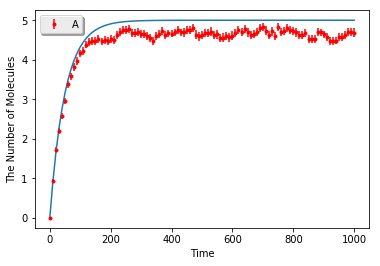

K 3.301358965615803
96
vol 1 1
vol 1 2.6680439930645834


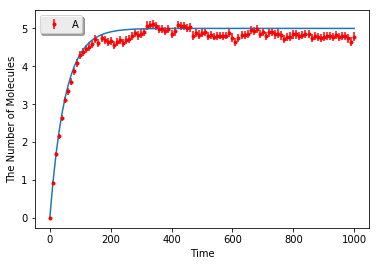

K 3.7415401610312435
144
vol 1 1
vol 1 2.7492311652532964


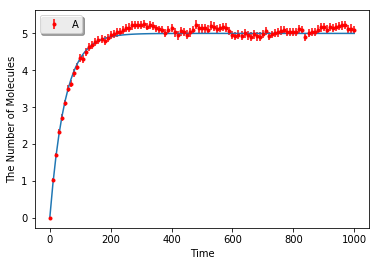

K 4.6769252012890545
216
vol 1 1
vol 1 2.111409534914532


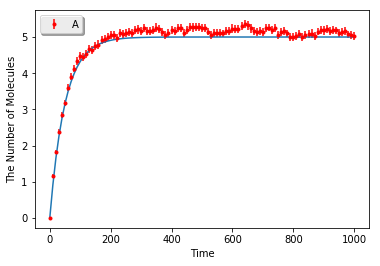

K 5.612310241546865
384
vol 1 1
vol 1 2.1722320318050747


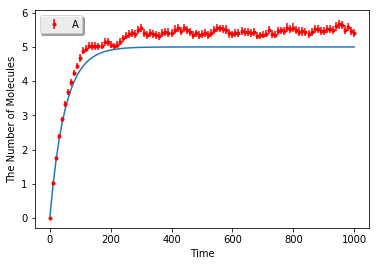

K 7.015387801933581
640
vol 1 1
vol 1 1.8536380004736634


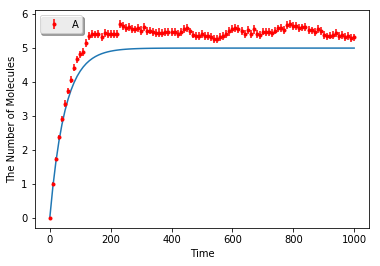

K 9.353850402578109
1440
vol 1 1
vol 1 1.75950794576211


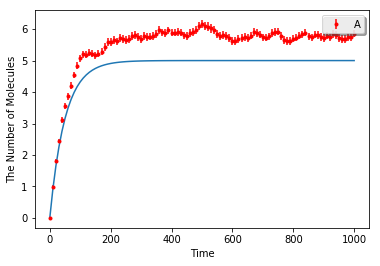

K 11.22462048309373
2352
vol 1 1
vol 1 1.6631151493507603


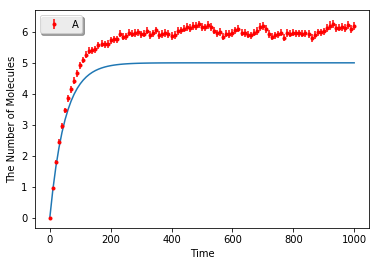

K 14.030775603867163
3584
vol 1 1
vol 1 1.2975466003315645


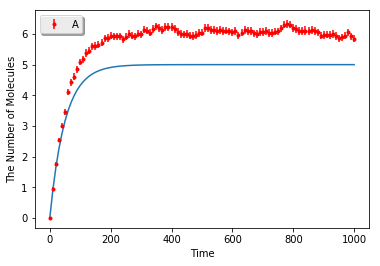

In [10]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

simrun=400#0#00
duration = 1000
#rm = 0.005
D=0.1
nproc=60
L=1#cbrt(10)
k0= 0.1
keff=0.02
method='multiprocessing'
Mean=[]
Ks=[]
nb=1*L**3
rlist=[0.2,0.17,0.15,0.12,0.1,0.08,0.06,0.05,0.04]#,0.01]
acv=[]
for rm in rlist:
    K=2.**(-5./6)*L/rm
    print('K',K)
    shape=tuple(spatiocyte.SpatiocyteWorld.calculate_shape(Real3(L,L,L),rm))
    nv=shape[0]*shape[1]*shape[2]      
    print(nv)
    def singlerun(solver='ode',intrinsic=False,simrun=1):   
        V = L**3 
        #M = max(int(min(cbrt(Nas), L / (2 * rm))), 3)
        if solver=='spa':
            solver=("spatiocyte",rm)
            V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),rm)
        elif solver=='egfrd':
            solver = ('egfrd', Integer3(M, M, M)) 
        elif solver=='meso':
            solver = ('meso', Integer3(K,K,K),2*rm)              
        acv.append(V)
        print('vol',L**3,V)

        with species_attributes():
            A | {'D': D, 'radius':rm}
            B | {'D': 0, 'radius':rm}
            E | {'D': 0, 'radius':rm}

        with reaction_rules():
            E > A | k0/nv
            A + E> E+A |  6*2**0.5 *D*rm   
            A + B >E+B | keff*V            
            #A>E | keff
                       
        m1 = get_model()
        
        with species_attributes():
            A | {'D': D, 'radius':rm}
            B | {'D': 0, 'radius':rm}

        with reaction_rules():
            ~A > A | k0/V
            A > ~A | keff
            #A + B >B | keff*V
        m2 = get_model()        

        #print('av={:.3},intrinsic={}'.format(float(V),intrinsic))
        #print('kon={:.3},koff={:.3},kd={:.3},keff={:.3},kfactor={:.3}'.format(kon,(ka if intrinsic else keff),kd,keff,ka/kd))
        if simrun >1 :
            if solver=='meso':
                obs=ensemble.ensemble_simulations(duration,n=simrun, y0={'B':nb},model=m2, solver=solver,volume=ones()*L,species_list=["A"],return_type='observer',nproc=nproc,method=method)#,return_type="observer")
            else:                            
                obs=ensemble.ensemble_simulations(duration,n=simrun, y0={'E':nv-nb,'B':nb},model=m1, solver=solver,volume=ones()*L,species_list=["A"],return_type='observer',nproc=nproc,method=method)#,return_type="observer")                
        else:
            obs=run_simulation(duration,model=m2,y0={'B':nb},return_type='observer',species_list=['A'],solver=solver,volume=ones()*L)
        return obs

    obs1=singlerun('ode',False,1)
    obs2=singlerun('spa',True,simrun)
    #obs3=singlerun('meso',False,simrun)        
    data2 = np.array(obs2.data()).T
    meana=np.mean(data2[1][50:])
    #print('A',meana)
    Mean.append(meana)
    Ks.append(K)
    viz.plot_number_observer(obs2,'r.',obs1,'k-')#,obs2,'g.')
    #obs3=singlerun('egfrd',True,simrun)
    #obs4=singlerun('gillespie',False,simrun)
    #write('/home/chew/outputdata/sturrock_bd_ode_rm{:.3}_Nas5'.format(rm),obs1)
    #write('/home/chew/outputdata/sturrock_bd_spa_rm{:.3}_Nas5_10k'.format(rm),obs2)
    #write('/home/chew/outputdata/sturrock_bd_egfrd_rm{:.3}_Nas5_10k'.format(rm),obs3)

[4.6549509803921563, 4.8154411764705882, 5.0674509803921568, 5.1489215686274505, 5.4652450980392153, 5.4637254901960777, 5.7951470588235292, 6.0170098039215691, 6.0707843137254915]
[1, 2.8963093757400995, 1, 2.6680439930645834, 1, 2.7492311652532964, 1, 2.111409534914532, 1, 2.1722320318050747, 1, 1.8536380004736634, 1, 1.75950794576211, 1, 1.6631151493507603, 1, 1.2975466003315645]
[2.8061551207734325, 3.301358965615803, 3.7415401610312435, 4.6769252012890545, 5.612310241546865, 7.015387801933581, 9.353850402578109, 11.22462048309373, 14.030775603867163]
[4.6549509803921563, 4.8154411764705882, 5.0674509803921568, 5.1489215686274505, 5.4652450980392153, 5.4637254901960777, 5.7951470588235292, 6.0170098039215691, 6.0707843137254915]


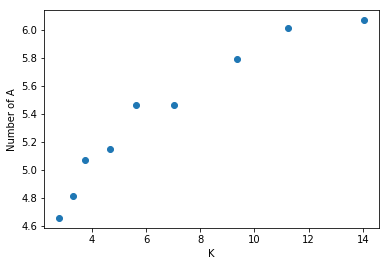

In [26]:
con=[i for i, j in zip(Mean,acv)]
print(Mean)
print(acv)
print(Ks)
print(con)
plt.plot(Ks,con,'o')
plt.xlabel('K')
plt.ylabel('Number of A')

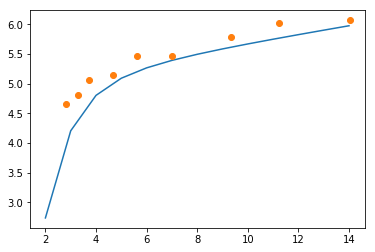

In [27]:
KK=np.arange(2,15,1)
k1=0.02
k2=0.1
L=1.
D=0.1
mA=[]
for K in KK:
    rm=2**(1./6) *L/K/2
    kd=4*3.14*rm*2*D
    #keff=kd*k1/(k1+kd)
    w=spatiocyte.SpatiocyteWorld(Real3(L,L,L),rm)
    #N=w.size()
    N=K**3
    k11=k1*kd/(k1+kd)
    #A.append(k2*(N/V-1)/(k2+k1))
    mA.append(k2*(N-1)/(k2+k11*N))
plt.plot(KK,mA,'-')
KK=[2.8061551207734325, 3.301358965615803, 3.7415401610312435, 4.6769252012890545, 5.612310241546865, 7.015387801933581, 14.030775603867163, 28.061551207734325]
plt.plot(Ks,con,'o')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


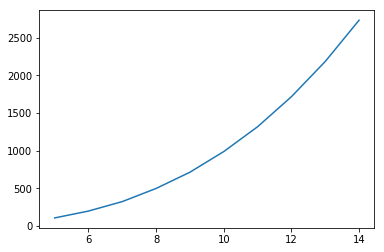

In [25]:
KK=np.arange(3,15,1)
k1=0.02
k2=0.1
L=1.
D=0.1
mA=[]
for K in KK:
    rm=2**(1./6) *L/K/2
    kd=4*3.14*rm*2*D
    #keff=kd*k1/(k1+kd)
    w=spatiocyte.SpatiocyteWorld(Real3(L,L,L),rm)
    V=w.actual_volume()
    #V=1
    #N=w.size()
    N=K**3
    #A.append(k2*(N/V-1)/(k2+k1))
    mA.append(0.5*(N-1+((1-N)**2-4*N*k2*V*V/k1)**0.5))
plt.plot(KK,mA,'-')


In [11]:
0.02*10/0.11

1.8181818181818183

In [12]:
L=1.
rm=0.02
spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),rm)

1.1295606565386387

In [22]:
0.1*(10**3 -1)/(0.1+0.02)

832.5